In [1]:
# arrays
import numpy as np

# unpacking files
import tarfile

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.table import Table

# plotting
from matplotlib import pyplot as plt

# sklearn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score


# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

In [2]:
tab = Table.read('3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat', format='ascii').to_pandas()

In [3]:
tab

,id,field,ra,dec,x,y,z_spec,z_peak,faper_F140W,eaper_F140W,...,flags,f140w_flag,star_flag,use_phot,near_star,nexp_f125w,nexp_f140w,nexp_f160w,lmass,Av
0,1.0,AEGIS,215.222382,53.004185,9590.50,3057.30,-1.0000,0.0100,-82.0410,-82.041000,...,0,0,1,0,0,2,0,3,7.51,1.1
1,2.0,AEGIS,215.096588,52.918053,16473.20,3150.20,-1.0000,0.0100,3.5078,0.074233,...,3,0,0,0,0,4,4,4,5.62,0.1
2,3.0,AEGIS,215.161469,52.959461,13060.10,2982.30,-1.0000,0.2062,-1.9043,-1.904300,...,1,0,0,1,0,2,0,2,9.00,1.1
3,4.0,AEGIS,215.305298,53.052921,5422.80,2692.10,-1.0000,0.0355,-72.3250,-72.325000,...,0,0,0,0,0,1,0,1,4.78,0.4
4,5.0,AEGIS,215.041840,52.871273,19894.60,2834.40,-1.0000,0.3427,1890.5000,0.133300,...,0,1,2,0,1,0,3,0,11.57,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207962,44098.0,UDS,34.363106,-5.122067,14578.84,11076.42,-1.0000,0.1852,188.8200,0.170750,...,0,1,2,0,0,0,3,0,10.21,0.2
207963,44099.0,UDS,34.333569,-5.123219,16343.92,11007.12,-1.0000,0.6716,1.7193,0.129080,...,0,1,2,0,0,0,3,0,8.49,0.7
207964,44100.0,UDS,34.363682,-5.123123,14544.39,11013.01,1.4196,2.7489,1.3829,0.113830,...,0,1,2,0,0,0,4,0,9.08,1.4
207965,44101.0,UDS,34.556389,-5.123040,3028.23,11017.04,-1.0000,1.1716,-99.0000,-99.000000,...,1,0,0,0,0,1,0,2,10.55,1.0


In [4]:
tab.columns

Index(['id', 'field', 'ra', 'dec', 'x', 'y', 'z_spec', 'z_peak', 'faper_F140W',
       'eaper_F140W', 'faper_F160W', 'eaper_F160W', 'f_F606W', 'e_F606W',
       'f_F814W', 'e_F814W', 'f_F125W', 'e_F125W', 'f_F140W', 'e_F140W',
       'f_F160W', 'e_F160W', 'tot_cor', 'kron_radius', 'a_image', 'b_image',
       'flux_radius', 'fwhm_image', 'flags', 'f140w_flag', 'star_flag',
       'use_phot', 'near_star', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w',
       'lmass', 'Av'],
      dtype='object')

---

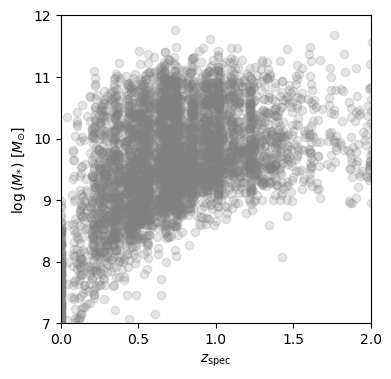

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(tab.z_spec, tab.lmass, alpha=0.2, color='grey')
ax.set_xlim(0, 2)
ax.set_ylim(7, 12)
ax.set_xlabel(r'$z_{\rm spec}$')
ax.set_ylabel(r'$\log{(M_{*})}\,\,[M_{\odot}]$')

plt.show()

In [6]:
tab = tab[tab.lmass > 9].copy()

In [7]:
target = 'z_spec'  # spectroscopic redshift
features = [col for col in tab.columns if (col != target)]

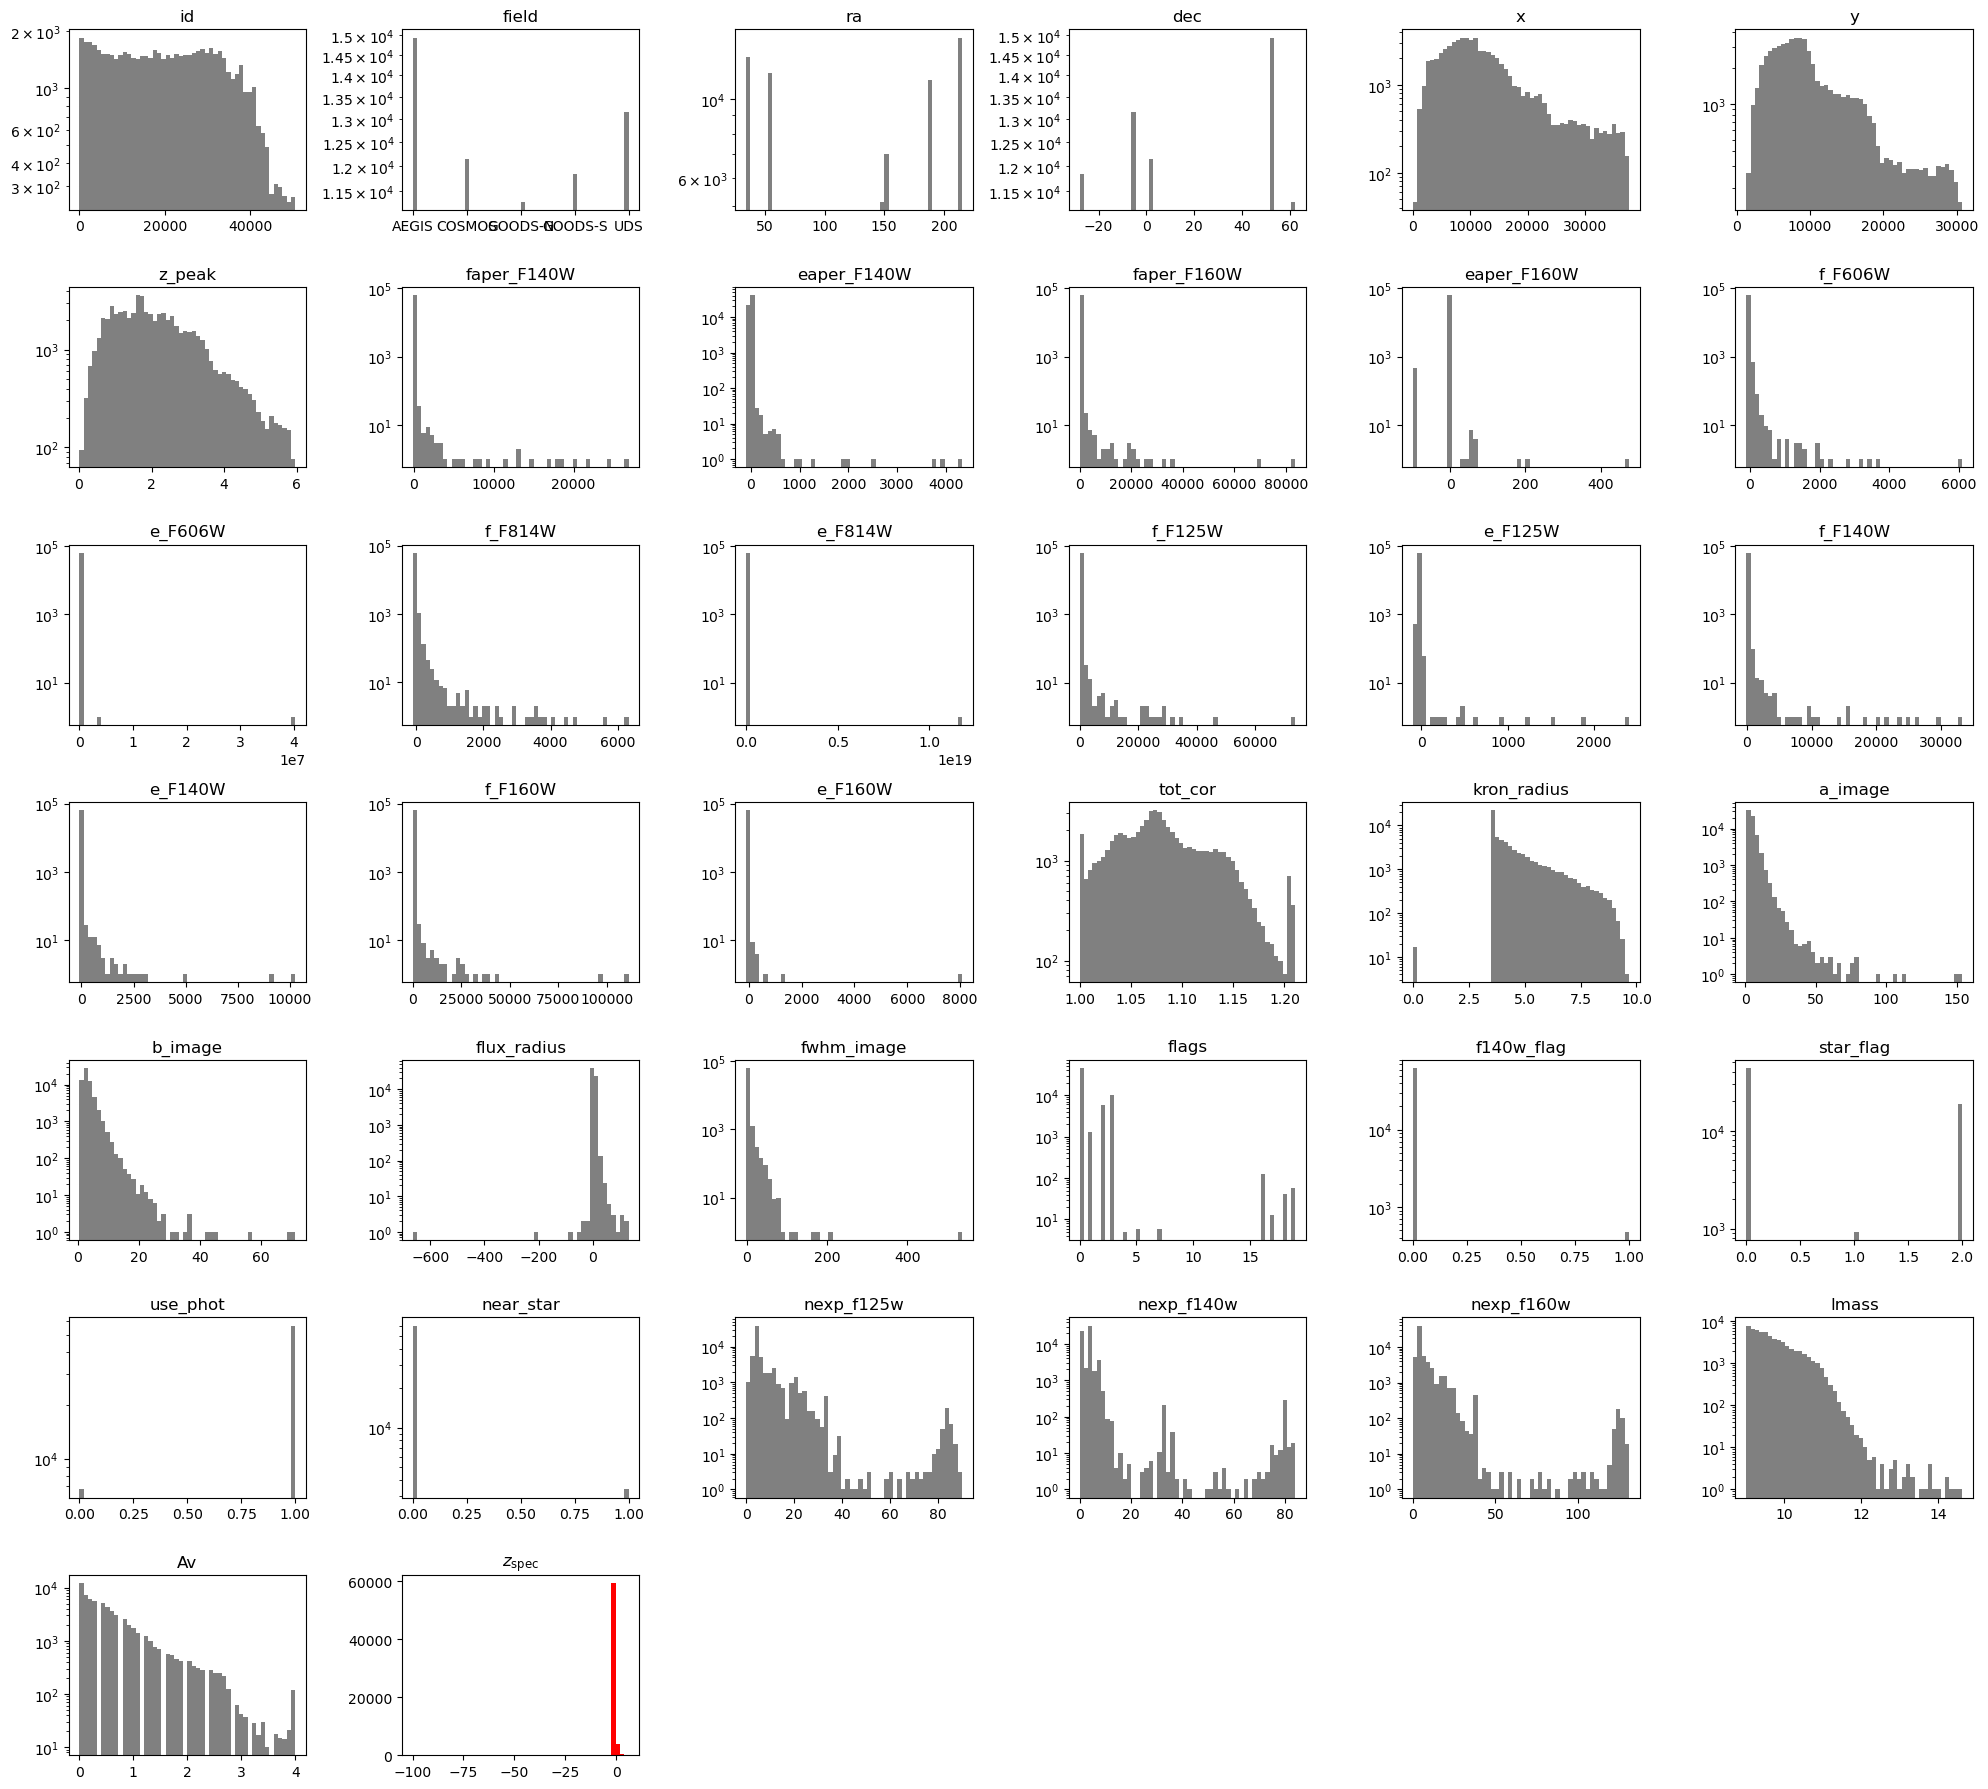

In [8]:
fig = plt.figure(0, [20,18])

for k, feat in enumerate(features):
    ax = fig.add_subplot(7, 6, k+1)
    ax.hist(tab[feat], bins=50, log=True, color='grey')
    ax.set_title(feat)

ax = fig.add_subplot(7, 6, len(features)+1)
ax.hist(tab[target], bins=50, color='red')
ax.set_title(r'$z_{\rm spec}$')

plt.tight_layout()
plt.show()

## Preprocessing

In [9]:
features = [col for col in features if (col != 'Av') and (col != 'lmass') and (col != 'z_peak') 
            and (col != 'flags') and (col != 'f140w_flag') and (col != 'star_flag') 
            and (col != 'use_phot') and (col != 'near_star')]

# Av, lmass, z_peak -> Data leakage problem
# flags, f140w_flag, star_flag, use_phot, near_star -> Filtering data to avoid leakage

In [10]:
tab = tab[(tab[target] > 0)].copy()

In [11]:
tab

,id,field,ra,dec,x,y,z_spec,z_peak,faper_F140W,eaper_F140W,...,flags,f140w_flag,star_flag,use_phot,near_star,nexp_f125w,nexp_f140w,nexp_f160w,lmass,Av
26,27.0,AEGIS,215.278076,53.036762,6798.20,2805.00,0.7405,0.6806,-71.0650,-71.06500,...,2,0,0,1,0,2,0,2,9.23,1.1
69,70.0,AEGIS,215.244797,53.015137,8565.00,2871.10,1.1193,1.0916,-60.6090,-60.60900,...,3,0,0,1,0,2,0,2,9.39,0.1
82,83.0,AEGIS,215.302460,53.055332,5379.80,2864.20,0.7383,0.7250,-40.9920,-40.99200,...,0,0,0,1,0,2,0,2,9.55,0.5
144,145.0,AEGIS,215.281769,53.042686,6441.80,2935.60,0.7365,0.7842,-33.7210,-33.72100,...,0,0,0,1,0,4,0,4,9.13,0.2
154,155.0,AEGIS,215.299683,53.055229,5449.70,2936.00,1.1371,1.1587,-54.5630,-54.56300,...,0,0,0,1,0,2,0,2,9.68,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205837,41973.0,UDS,34.299271,-5.132092,18393.59,10474.45,0.6320,0.5790,-99.0000,-99.00000,...,0,0,0,1,0,4,0,4,10.22,2.4
206257,42393.0,UDS,34.295635,-5.127980,18610.94,10721.14,0.8240,0.8001,-99.0000,-99.00000,...,3,0,0,1,0,4,0,4,10.84,2.4
207042,43178.0,UDS,34.495361,-5.125964,6675.25,10842.28,0.2040,0.2097,-99.0000,-99.00000,...,0,0,0,1,0,4,0,4,9.40,1.6
207646,43782.0,UDS,34.317093,-5.126375,17328.49,10817.60,2.3200,1.3523,-99.0000,-99.00000,...,0,0,0,0,0,2,0,2,10.96,0.0


In [12]:
label_encoder = LabelEncoder()
tab['field'] = label_encoder.fit_transform(tab['field'])

# AEGIS (0), COSMOS (1), GOODS-North (2), GOODS-South (3), UKIDSS UDS (4)

In [13]:
errors = [col for col in features if (col[:1] == 'e') and (col[-1:] == 'W')]

for error in errors:
    tab[error] = np.where(tab[error] < -90, tab[error].median(), tab[error])

In [14]:
errors  

['eaper_F140W',
 'eaper_F160W',
 'e_F606W',
 'e_F814W',
 'e_F125W',
 'e_F140W',
 'e_F160W']

In [15]:
tab.columns

Index(['id', 'field', 'ra', 'dec', 'x', 'y', 'z_spec', 'z_peak', 'faper_F140W',
       'eaper_F140W', 'faper_F160W', 'eaper_F160W', 'f_F606W', 'e_F606W',
       'f_F814W', 'e_F814W', 'f_F125W', 'e_F125W', 'f_F140W', 'e_F140W',
       'f_F160W', 'e_F160W', 'tot_cor', 'kron_radius', 'a_image', 'b_image',
       'flux_radius', 'fwhm_image', 'flags', 'f140w_flag', 'star_flag',
       'use_phot', 'near_star', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w',
       'lmass', 'Av'],
      dtype='object')

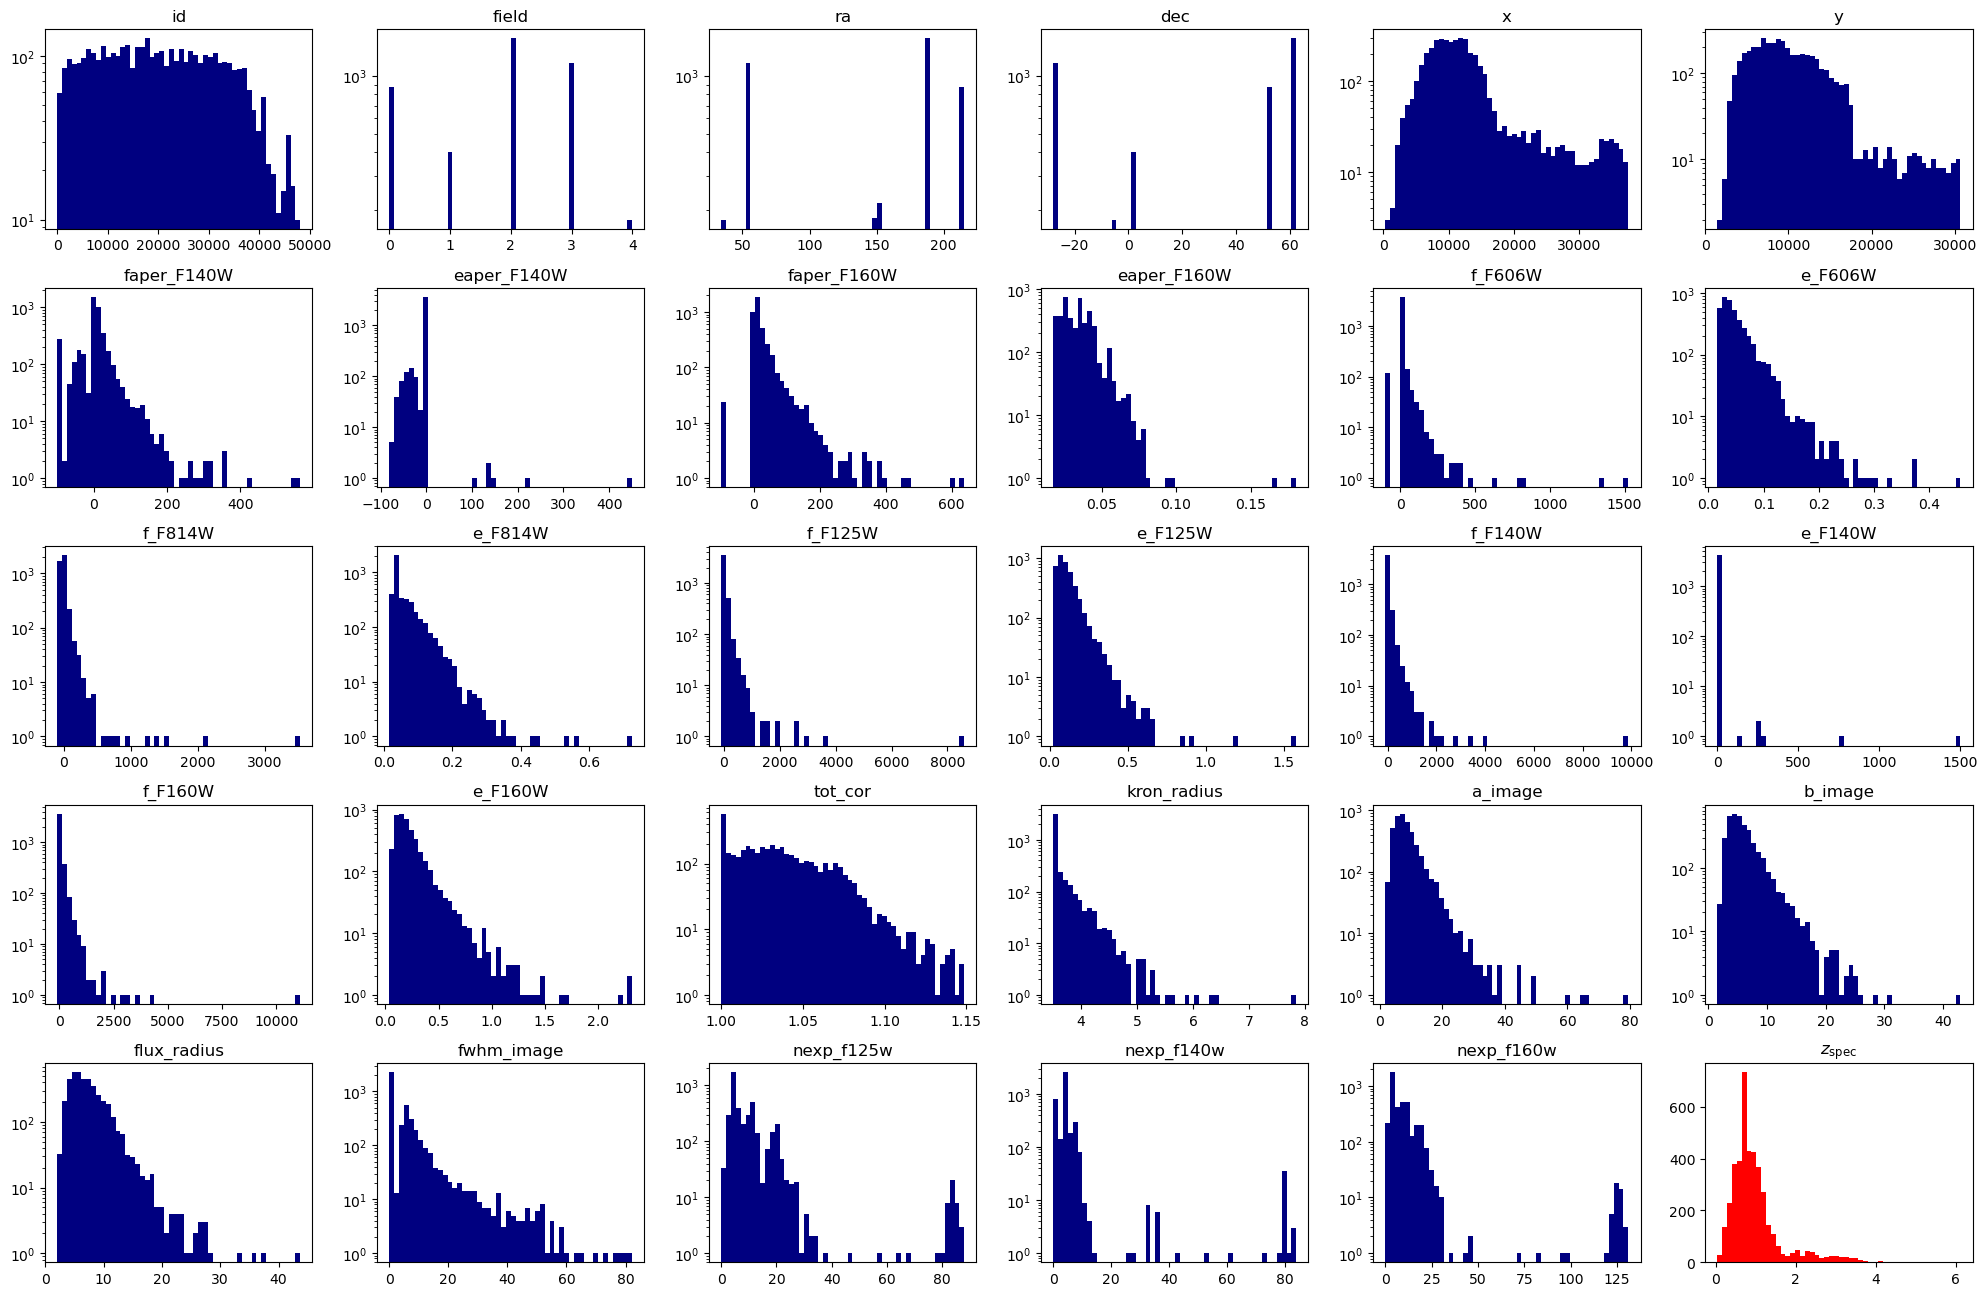

In [16]:
fig = plt.figure(0, [20, 18])

for k, feat in enumerate(features):
    ax = fig.add_subplot(7, 6, k+1)
    ax.hist(tab[feat], bins=50, log=True, color='navy')
    ax.set_title(feat)

ax = fig.add_subplot(7, 6, len(features)+1)
ax.hist(tab[target], bins=50, color='red')
ax.set_title(r'$z_{\rm spec}$')

plt.tight_layout()
plt.show()

---

In [17]:
X = tab[features].values
y = tab[target].values

In [18]:
indices = np.arange(len(y))

# first reserve 70% of the data for training, 30% for validation
X_train, X_validate, y_train, y_validate, indices_train, indices_validate = train_test_split(X, y, indices, test_size=0.3, random_state=42)

# second, split the validation set in half to obtain validation and test sets. 
X_validate, X_test, y_validate, y_test, indices_validate, indices_test = train_test_split(X_validate, y_validate, indices_validate, test_size=0.5, random_state=42)

## Run a model

### Decision Tree Model

In [19]:
# Initialize the model
dtree = DecisionTreeRegressor()

# Fit the model parameters using the training dataset
dtree.fit(X_train, y_train)

DecisionTreeRegressor()

MSE = 0.2493


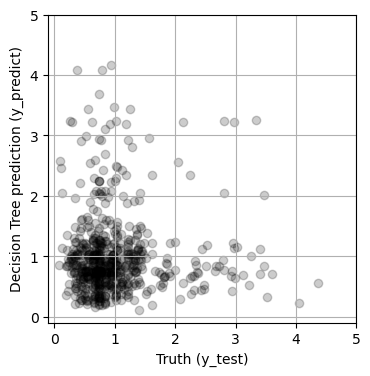

In [20]:
y_predict = dtree.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_validate, y_predict, alpha=0.2, color='black')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Decision Tree prediction (y_predict)')
plt.show()

In [21]:
DecisionTreeRegressor().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [22]:
# Control parameters
hyperparameter_distributions = {
    'max_depth': np.arange(1, 20, 2).astype(int),
    'min_samples_split': np.arange(5, 105, 10).astype(int),
    'min_samples_leaf': np.arange(5, 105, 10).astype(int)
}

random_search = RandomizedSearchCV(
    dtree, 
    param_distributions=hyperparameter_distributions,
    n_iter=100
)

random_search.fit(X_train, y_train.flatten())

RandomizedSearchCV(estimator=DecisionTreeRegressor(), n_iter=100,
                   param_distributions={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_leaf': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95]),
                                        'min_samples_split': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95])})

In [23]:
print(random_search.best_params_)

{'min_samples_split': 65, 'min_samples_leaf': 15, 'max_depth': 7}


MSE = 0.1532


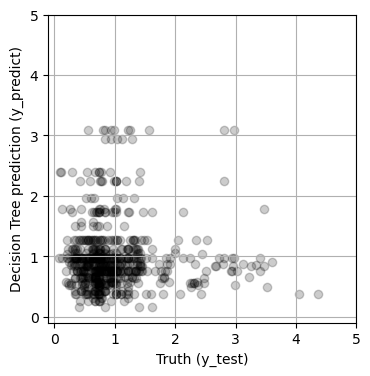

In [24]:
y_predict = random_search.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_validate, y_predict, alpha=0.2, color='black')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Decision Tree prediction (y_predict)')
plt.show()

### Random Foreset Model

In [25]:
# use the same parameters as the Decision Tree
params = {
    "min_samples_split": 15,
    "min_samples_leaf": 5,
    "max_depth": 15,
}

# Initialize the model
rf = RandomForestRegressor(**params)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=15)

MSE = 0.1143


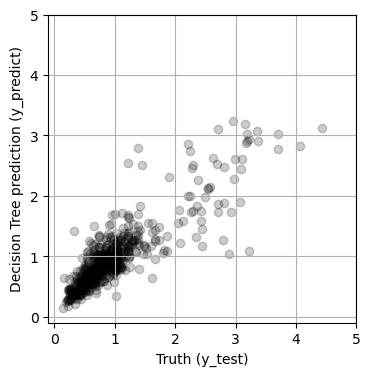

In [26]:
y_predict = rf.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(y_test, y_predict, alpha=0.2, color='black')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Decision Tree prediction (y_predict)')
plt.show()

### Evaluation

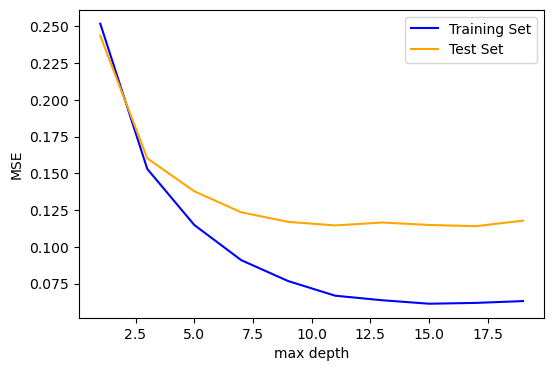

In [27]:
max_depths = np.arange(1, 20, 2).astype(int)

train_mse = []
test_mse = []
for depth in max_depths:

    params = {
        "min_samples_split": 15,
        "min_samples_leaf": 5,
        "max_depth": depth,
    }
    rff = RandomForestRegressor(**params)
    rff.fit(X_train, y_train)
    
    y_predict_train = rff.predict(X_train)
    y_predict_test = rff.predict(X_test)
    
    train_mse.append(mean_squared_error(y_train, y_predict_train))
    test_mse.append(mean_squared_error(y_test, y_predict_test))

    
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(max_depths, train_mse, color='blue', label='Training Set')
ax.plot(max_depths, test_mse, color='orange', label='Test Set')
ax.set_xlabel('max depth')
ax.set_ylabel('MSE')
ax.legend()

plt.show()

In [28]:
# K-fold cross validation
cv = cross_validate(
    estimator=rf, 
    X=X, 
    y=y, 
    cv=5, # number of folds
    scoring='neg_mean_squared_error'
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: -0.146 +/- 0.058


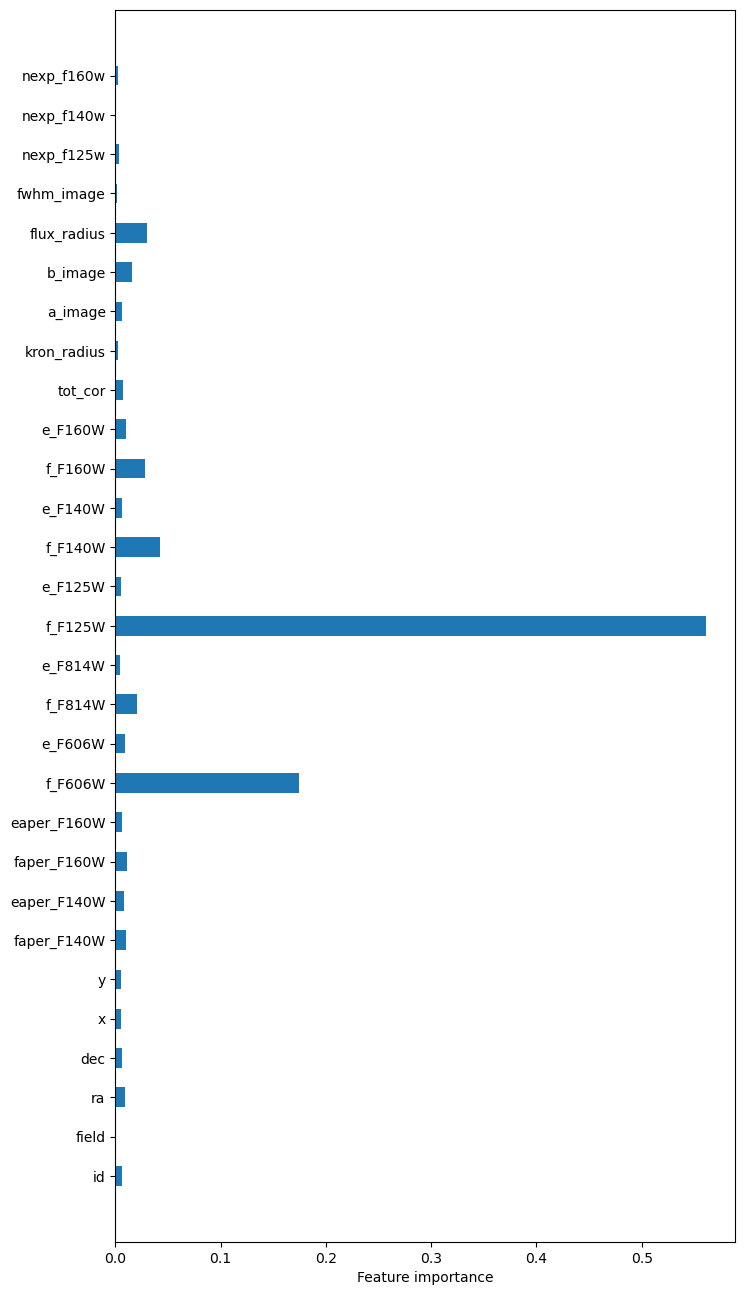

In [29]:
importances = rf.feature_importances_

fig = plt.figure(0, [8, 16])
ax = fig.add_subplot(111)
ax.barh(np.arange(X.shape[1]), importances, 
        align='center', 
        height=0.5, 
        tick_label=features)
ax.set_xlabel("Feature importance")

plt.show()

The most “important” features in this model are the F125W and F606W fluxes. Parameters such as id, ra, dec, x, and y understandably have very little influence on the predictions.

---

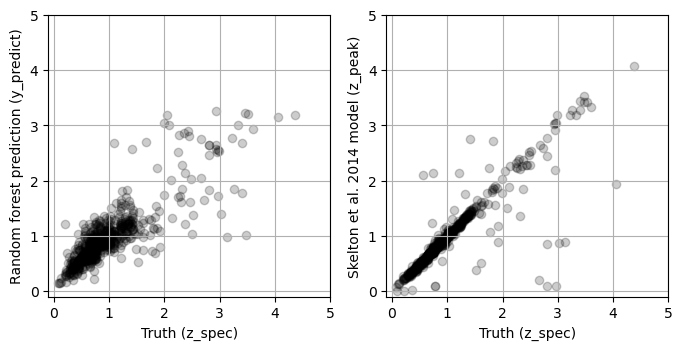

In [30]:
y_predict_validate = rf.predict(X_validate)
y_skelton2014 = tab['z_peak'].values[indices_validate]

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].scatter(y_validate, y_predict_validate, alpha=0.2, color='black')
ax[0].set_aspect('equal')
ax[0].set_xlim(-0.1, 5)
ax[0].set_ylim(-0.1, 5)
ax[0].grid()
ax[0].set_xlabel('Truth (z_spec)')
ax[0].set_ylabel('Random forest prediction (y_predict)')

ax[1].scatter(y_validate, y_skelton2014, alpha=0.2, color='black')
ax[1].set_aspect('equal')
ax[1].set_xlim(-0.1, 5)
ax[1].set_ylim(-0.1, 5)
ax[1].grid()
ax[1].set_xlabel('Truth (z_spec)')
ax[1].set_ylabel('Skelton et al. 2014 model (z_peak)')

plt.show()

In [31]:
print(f"Random forest MSE = {mean_squared_error(y_validate, y_predict_validate):.4f}")
print(f"Skelton et al. (2014) MSE = {mean_squared_error(y_validate, y_skelton2014):.4f}")

Random forest MSE = 0.1379
Skelton et al. (2014) MSE = 0.0928
